## Window for compressed parameters
In this notebook we study how to relate measurements of compressed parameters to the underlying theory (in terms of $P^{\theta\theta}$ band powers, Alcock-Paczynski, etc.)

### Define the likelihood of compressed parameters

In [1]:
import numpy as np

from desilike import setup_logging
from desilike.theories.galaxy_clustering import StandardPowerSpectrumTemplate, DirectPowerSpectrumTemplate, BandVelocityPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, BoxFootprint, ObservablesCovarianceMatrix
from desilike.likelihoods import ObservablesGaussianLikelihood

setup_logging()

z, b1 = 1., 2.
order = 1
kwargs_template = {'only_now': 'peakaverage', 'z': z, 'fiducial': 'DESI'}
theory_compression = KaiserTracerPowerSpectrumMultipoles(template=StandardPowerSpectrumTemplate(**kwargs_template, apmode='qap'))
theory_compression.params['b1'].update(fixed=False, value=b1)
observable_compression = TracerPowerSpectrumMultipolesObservable(klim={0: [0.01, 0.15, 0.01], 2: [0.01, 0.15, 0.01], 4: [0.01, 0.15, 0.01]},
                                                                 data={},
                                                                 theory=theory_compression)

footprint = BoxFootprint(volume=1e10, nbar=1e-3)
cov = ObservablesCovarianceMatrix(observable_compression, footprints=footprint)()
likelihood_compression = ObservablesGaussianLikelihood(observables=observable_compression, covariance=cov)

# Emulate the theory, to make it automatically differentiable
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(theory_compression, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
emulator.fit()
# All parameters to be solved analytically
observable_compression.init.update(theory=emulator.to_calculator())
for param in likelihood_compression.varied_params:
    param.update(prior=None, derived='.best')

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1329: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


[000002.71] [0/1] 02-24 01:22  Emulator                  INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].
[000002.71] [0/1] 02-24 01:22  Emulator                  INFO     Found varying ['fsigmar', 'power'] and fixed ['k', 'ells'] outputs.
[000002.72] [0/1] 02-24 01:22  Differentiation           INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].
[000003.43] [0/1] 02-24 01:22  Differentiation           INFO     Using finite-differentiation for parameter qap.
[000003.78] [0/1] 02-24 01:22  Differentiation           INFO     Using auto-differentiation for parameter df.
[000003.83] [0/1] 02-24 01:22  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000003.87] [0/1] 02-24 01:22  Differentiation           INFO     Using auto-differentiation for parameter sn0.
[000003.87] [0/1] 02-24 01:22  Differentiation           INFO     qap grid is [0.998 1.    1.002].


### Estimate window by varying the underlying model of the data

In [2]:
# Theory is band power + AP
template_band = BandVelocityPowerSpectrumTemplate(**kwargs_template)
theory_band = KaiserTracerPowerSpectrumMultipoles(template=template_band)
theory_band.params['b1'].update(fixed=False, value=b1)

# This calculator outputs best fit compressed parameters, as a function of underlying theory
from desilike.base import BaseCalculator

class CompressionWindow(BaseCalculator):

    def initialize(self, likelihood, theory, quantities):
        self.likelihood = likelihood
        self.observable = self.likelihood.observables[0].deepcopy()
        self.quantities = [str(name) for name in quantities]
        self.kp = np.unique(np.concatenate(self.observable.k))
        #self.kp = np.linspace(0.009, 0.16, 30)
        theory.init['template'].init.update(kp=self.kp)
        for param in theory.params:
            param.update(fixed=True)
        self.observable.init.update(theory=theory)
        self.runtime_info.requires = [self.observable]

    def calculate(self):
        self.likelihood.flatdata = self.observable.flattheory.copy()
        for i in range(3):
            self.likelihood()  # find parameter best fit (iteratively in case order > 1)
        #self.likelihood.observables[0].plot(show=True)
        self.values = {}
        for quantity in self.quantities:
            self.values[quantity] = self.likelihood.runtime_info.pipeline.param_values[quantity]

    def get(self):
        return self.values

    def __getstate__(self):
        state = {'compression_{}'.format(quantity): value for quantity, value in self.values.items()}
        for name in ['quantities', 'kp']: state[name] = getattr(self, name)
        return state

    def __setstate__(self, state):
        for name in ['quantities', 'kp']: setattr(self, name, state[name])
        self.values = {quantity: state['compression_{}'.format(quantity)] for quantity in self.quantities}

        
compression_window = CompressionWindow(likelihood=likelihood_compression, theory=theory_band, quantities=theory_compression.template.varied_params)
emulator = Emulator(compression_window, engine=TaylorEmulatorEngine(order=order))
emulator.set_samples()
emulator.fit()
emulated_compression_window = emulator.to_calculator()

[000005.88] [0/1] 02-24 01:22  Differentiation           INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].
[000007.70] [0/1] 02-24 01:22  Emulator                  INFO     Varied parameters: ['qap', 'ptt0', 'ptt1', 'ptt2', 'ptt3', 'ptt4', 'ptt5', 'ptt6', 'ptt7', 'ptt8', 'ptt9', 'ptt10', 'ptt11', 'ptt12', 'ptt13'].
[000007.70] [0/1] 02-24 01:22  Emulator                  INFO     Found varying ['compression_qap', 'compression_df'] and fixed ['quantities', 'kp'] outputs.
[000007.70] [0/1] 02-24 01:22  Differentiation           INFO     Varied parameters: ['qap', 'ptt0', 'ptt1', 'ptt2', 'ptt3', 'ptt4', 'ptt5', 'ptt6', 'ptt7', 'ptt8', 'ptt9', 'ptt10', 'ptt11', 'ptt12', 'ptt13'].
[000008.10] [0/1] 02-24 01:22  Differentiation           INFO     Using finite-differentiation for parameter qap.
[000008.46] [0/1] 02-24 01:22  Differentiation           INFO     Using finite-differentiation for parameter ptt0.
[000008.59] [0/1] 02-24 01:22  Differentiation           INFO     Using finite-d

### Let's test our window by fitting w0waCDM models

In [3]:
observable_compression.init.update(theory=theory_compression)
observable_direct = observable_compression.deepcopy()
template_direct = DirectPowerSpectrumTemplate(**kwargs_template)
theory_direct = KaiserTracerPowerSpectrumMultipoles(template=template_direct)
theory_direct.params['b1'].update(fixed=False, value=b1)
observable_direct.init.update(theory=theory_direct)

from desilike.profilers import MinuitProfiler

profiler = MinuitProfiler(likelihood_compression, seed=42)
bestfits, expected_no_window, expected_no_window_grid, expected_with_window = [], [], [], []

def get_expected_no_window(grid_coordinates=False):
    cosmo, fiducial = template_direct.cosmo, template_direct.fiducial
    fo = fiducial.get_fourier()
    r = 8.
    fsigma8_fid = fo.sigma_rz(r, template_direct.z, of='theta_cb')
    qper, qpar = cosmo.comoving_angular_distance(template_direct.z) / fiducial.comoving_angular_distance(template_direct.z), fiducial.efunc(template_direct.z) / cosmo.efunc(template_direct.z)
    qiso = qpar**(1. / 3.) * qper**(2. / 3.)
    qap = qpar / qper
    fo = cosmo.get_fourier()
    if grid_coordinates: r *= qiso
    df = fo.sigma_rz(r, template_direct.z, of='theta_cb') / fsigma8_fid
    return {'qiso': qiso, 'qap': qap, 'df': df}


def get_expected_with_window():
    cosmo, fiducial = template_direct.cosmo, template_direct.fiducial
    qper, qpar = cosmo.comoving_angular_distance(template_direct.z) / fiducial.comoving_angular_distance(template_direct.z), fiducial.efunc(template_direct.z) / cosmo.efunc(template_direct.z)
    qiso = qpar**(1. / 3.) * qper**(2. / 3.)
    qap = qpar / qper
    # Move pk_tt to grid coordinates
    pk_tt = 1. / qiso**3 * cosmo.get_fourier().pk_interpolator(of='theta_cb')(emulated_compression_window.kp / qiso, z=template_direct.z)
    # Compare to fiducial
    pk_tt /= fiducial.get_fourier().pk_interpolator(of='theta_cb')(emulated_compression_window.kp, z=template_direct.z)
    params = {'qap': qap, **{'ptt{:d}'.format(ik): ptt for ik, ptt in enumerate(pk_tt)}}
    return emulated_compression_window(**params)

params = {}
params['w0_fld'] = [-1.2, -1., -0.8]
params['wa_fld'] = [-0.3, 0., 0.3]
#params['Omega_m'] = [0.27, 0.3, 0.33]
#params['Omega_m'] = [0.2, 0.3, 0.4]
#params['h'] = [0.65, 0.7, 0.75]
import itertools
grid_params = [dict(zip(params.keys(), values)) for values in itertools.product(*params.values())]
for param in params:
    template_direct.params[param].update(fixed=False)

theories = []
for params in grid_params:
    likelihood_compression.flatdata = observable_direct(**params).flattheory
    theories.append(observable_direct.theory)
    profiles = profiler.maximize(niterations=3)
    profiler.profiles = None
    index = profiles.bestfit.logposterior.argmax()
    bestfits.append({param.name: (profiles.bestfit[param][index], profiles.error[param][index]) for param in profiles.bestfit.params(varied=True)})
    expected_no_window.append(get_expected_no_window(grid_coordinates=False))
    expected_no_window_grid.append(get_expected_no_window(grid_coordinates=True))
    expected_with_window.append(get_expected_with_window())
    #print('besfit', bestfits[-1])
    #print('no window', expected_no_window[-1])
    #print('no window grid', expected_no_window_grid[-1])
    #print('with window', expected_with_window[-1])

[000014.75] [0/1] 02-24 01:22  MinuitProfiler            INFO     Varied parameters: ['qap', 'df', 'b1', 'sn0'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:27: UserWarning: EisensteinHuNoWiggleEngine cannot cope with non-constant dark energy
  warnings.warn('{} cannot cope with non-constant dark energy'.format(self.__class__.__name__))


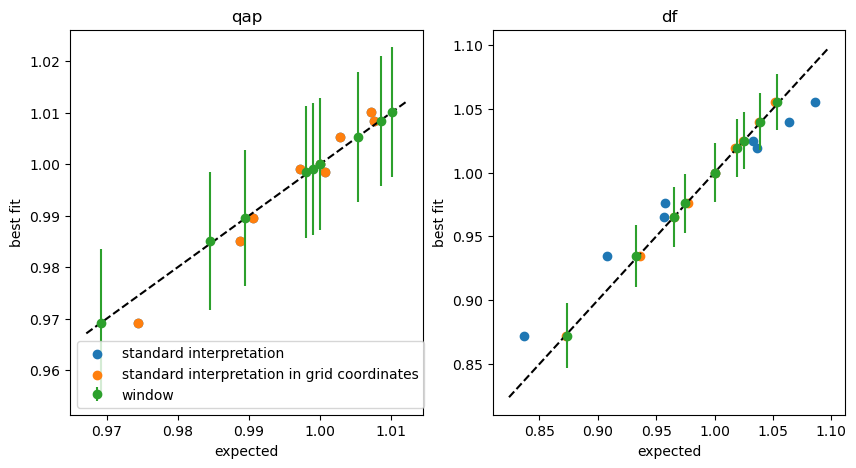

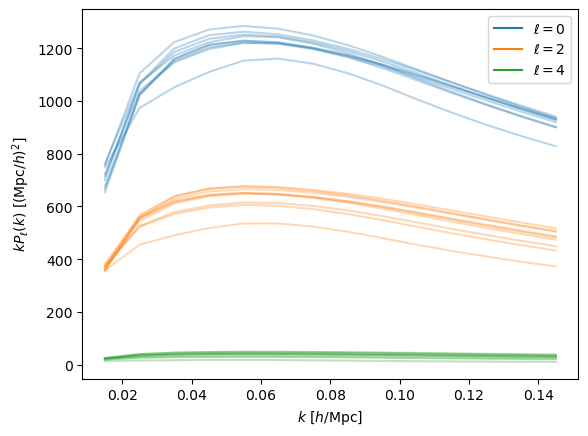

In [4]:
# Plots
params_compression = emulated_compression_window.quantities

from matplotlib import pyplot as plt
fig, lax = plt.subplots(1, len(params_compression), sharex=False, sharey=False, figsize=(len(params_compression) * 5, 5), squeeze=False)
lax = lax.flatten()
fig.subplots_adjust(hspace=0)
for iparam, param in enumerate(params_compression):
    ax = lax[iparam]
    ax.scatter([expected[param] for expected in expected_no_window], [bestfit[param][0] for bestfit in bestfits], color='C0', label='standard interpretation')
    ax.scatter([expected[param] for expected in expected_no_window_grid], [bestfit[param][0] for bestfit in bestfits], color='C1', label='standard interpretation in grid coordinates')
    ax.errorbar([expected[param] for expected in expected_with_window], [bestfit[param][0] for bestfit in bestfits], yerr=[bestfit[param][1] for bestfit in bestfits], color='C2', label='window', marker='o', linestyle='')
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='--', color='k')
    ax.set_xlabel('expected')
    ax.set_ylabel('best fit')
    ax.set_title(param)
lax[0].legend()
plt.show()

ax = plt.gca()
for ill, ell in enumerate(observable_direct.ells):
    for theory in theories:
        ax.plot(observable_direct.k[ill], observable_direct.k[ill] * theory[ill], color='C{:d}'.format(ill), alpha=0.3)
    ax.plot([], [], linestyle='-', color='C{:d}'.format(ill), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()